In [520]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import imageio

These are 2 of the handy functions we're gonna use in rest of the code.

In [521]:
def convert_bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def normalize(img):
    return cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)

Here we load source image, its corresponding mask and the target image. There is a resizing parameter name K which downsamples the image in order to perform faster. Since original images are already big, we downsample them by 2 to acheive the results faster and use less space.

In [522]:
k = 2
source = cv2.imread('res05.jpg')
height, width = source.shape[:2]
source = cv2.resize(source, (int(width/k), int(height/k)))
target = cv2.imread('res06.jpg')
target = cv2.resize(target, (int(width/k), int(height/k)))
mask = cv2.imread('mask-blend.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (int(width/k), int(height/k)))

Here is the Source image. 

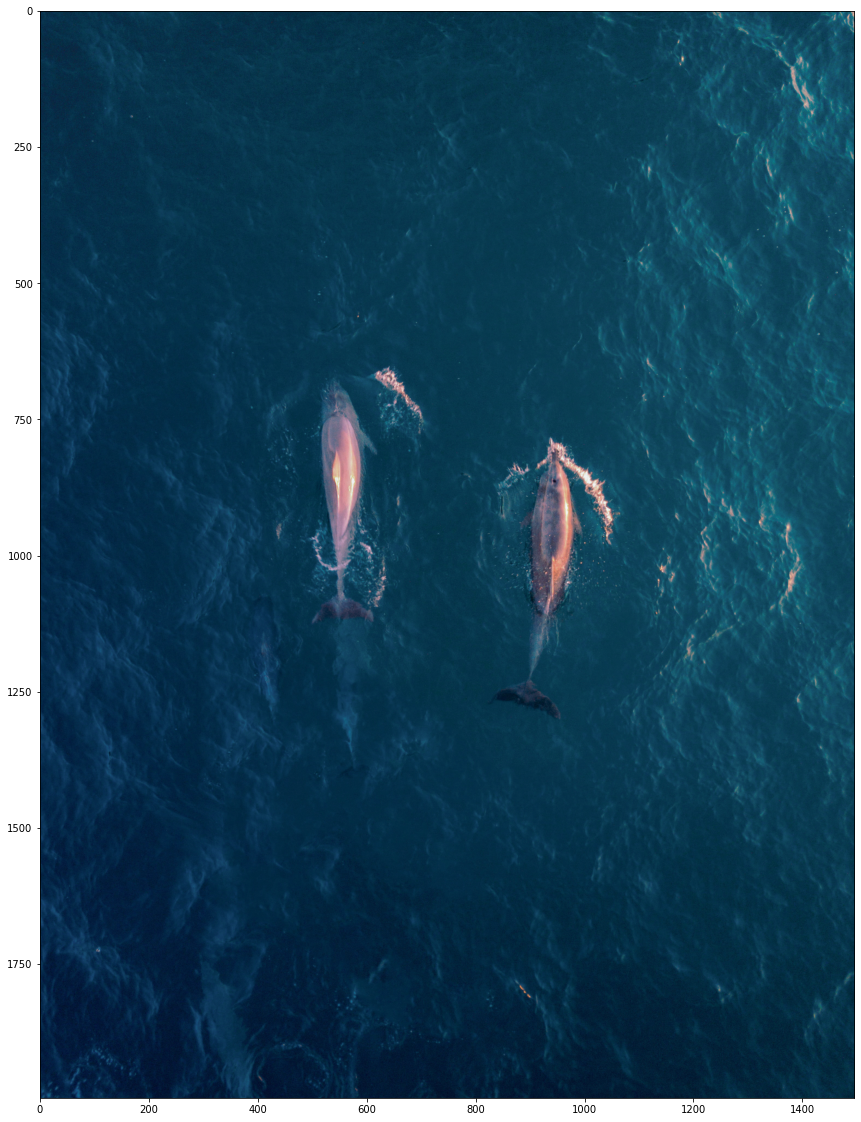

In [523]:
fig = plt.figure(figsize=(15, 20))
plt.imshow(convert_bgr_to_rgb(source))

Here is the Target image.

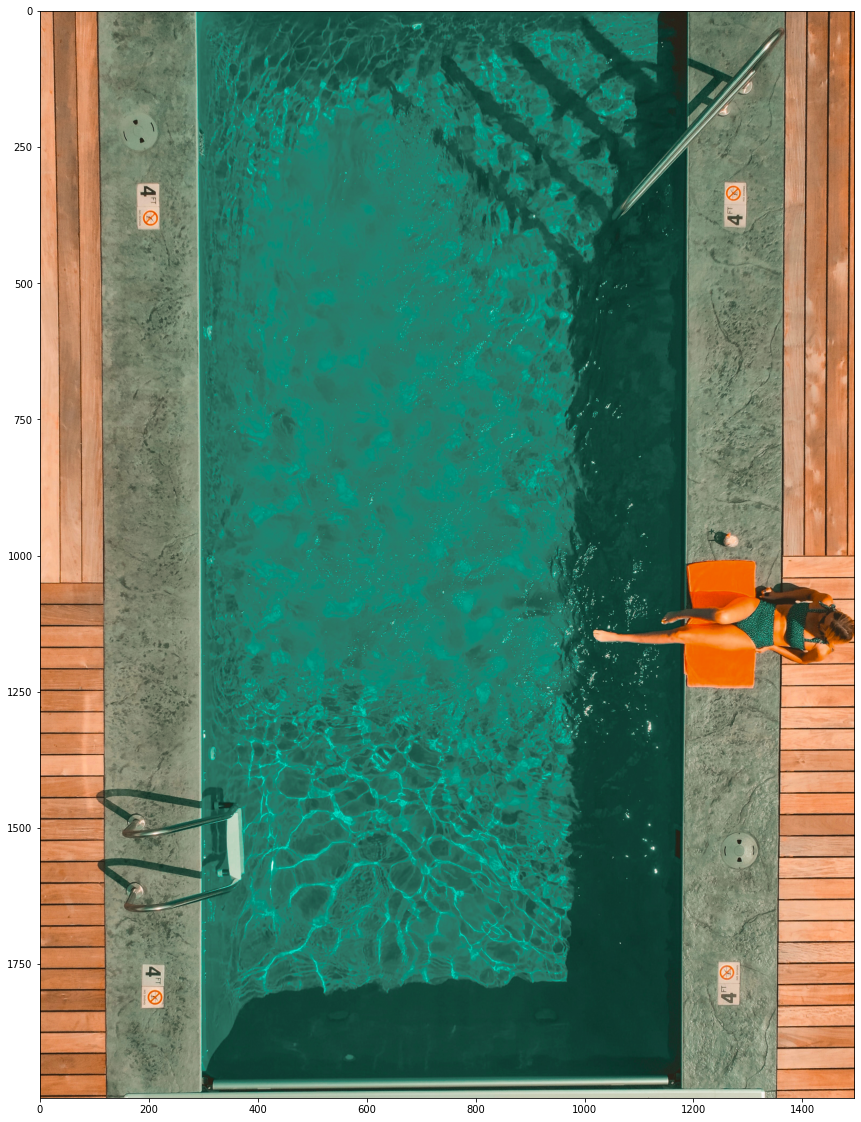

In [524]:
fig = plt.figure(figsize=(15, 20))
plt.imshow(convert_bgr_to_rgb(target))

Here is the mask. We're basically going to take the sharks from the first image and put them in the target image's pool.

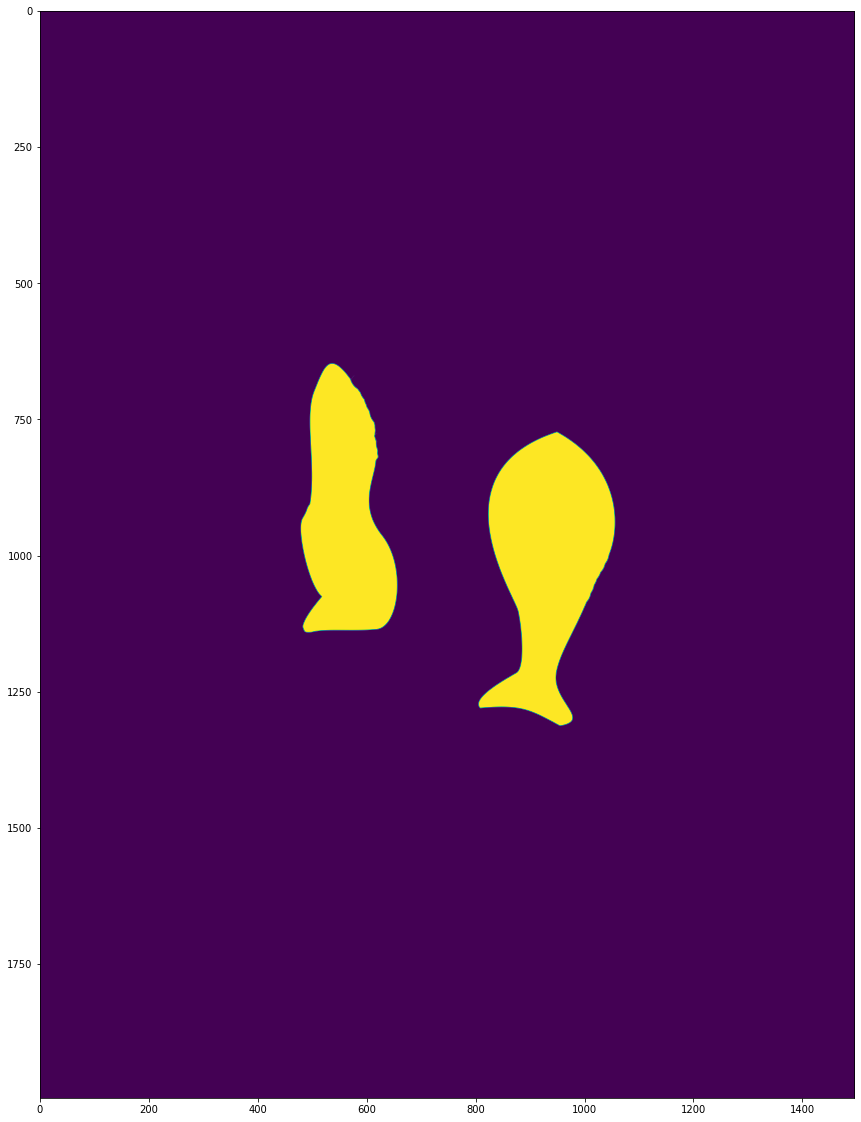

In [525]:
fig = plt.figure(figsize=(15, 20))
plt.imshow(mask)

Here we calculate laplacian for the purpose of demonstration. We're going to use source image laplacian to reconstruct sharks in the target image.

In [ ]:
ddepth = cv2.CV_64F
Laplacian = cv2.Laplacian(source, ddepth=ddepth)

In [ ]:
fig = plt.figure(figsize=(15, 20))
plt.imshow(Laplacian)

Here we extract the indexes of pixels within the mask.

In [ ]:
mask_indices = np.where(mask > 0)
mask_indices = list(zip(*mask_indices))

This is how many pixels we have to fill.

In [ ]:
np.count_nonzero(mask)


Forming a matrix with this size is almost impossibale and even if it's not, it's surely not optimized and can cause major issues. This matrix has a special proparty which is most of it's elements are zero. These types of matrices are called Sparse matrices. We use SciPy.Sparse in almost every step of our calcu(lation to make our algorithm as efficient and fast as possible.
If we assueme $Ax=b$, A is a matrix with shape $N \times N$, where $N$ is the number of pixels in the specified region. Each row of this matrix has an element $4$ and at most four more $-1$s and the rest of the row is zero. The $b$ side on the other hand is the laplacian value of correspong pixel(row). Filling the $A$ in the most naive way is probably not a good idea becuase we have to perform so many iterations. Therefore we use rectangle around the mask to have structured shape. Now we can index the (row, col) pairs that have to be -1 in much easier way. They all almost place diagnally with or without offset.

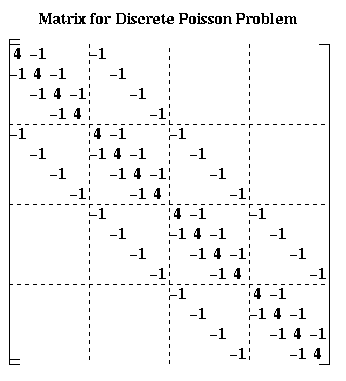

Most of the times we ignore the Laplacian of target image but in order to acheive a smoother texture on the water I dedicated a $0.25$ coefficient to target image laplacian and $0.75$ to source image laplacian.

After forming the matrices, we simply solve:

$$Ax=b$$

using scipy spsolve and then we just put back together the pixels to where they belong to. 

We apply a same procedure for each channel of the image and we finally merge them.

In [ ]:
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix
from scipy.sparse import diags
from scipy.sparse import csr_matrix
import scipy
import scipy.sparse
from scipy.sparse.linalg import spsolve

moves = [(1, 0), (0, 1), (-1, 0), (0, -1)]

def apply_on_channel(source_channel, target_channel, L, mask_v, A, height, width):
    source_channel_vector = source_channel.flatten()
    target_channel_vector = target_channel.flatten()
    ratio = 0.75
    b = L @ (ratio * source_channel_vector + (1-ratio) * target_channel_vector)
    b[mask_v==0] = target_channel_vector[mask_v==0]
    x = spsolve(A, b)
    x = x.reshape((height, width))
    return clip(x)

def generate_mask(A, y_max, x_max):
    for y in range(1, y_max - 1):
        for x in range(1, x_max - 1):
            if mask[y, x] == 0:
                k = x + y * x_max
                A[k, k], A[k, k + 1], A[k, k - 1], A[k, k + x_max], A[k, k - x_max]  = 1, 0, 0, 0, 0

def get_laplacian(n, m):

    Diag = scipy.sparse.lil_matrix((m, m))
    Diag.setdiag(-1, -1)
    Diag.setdiag(4)
    Diag.setdiag(-1, 1)
        
    A = scipy.sparse.block_diag([Diag] * n).tolil()
    A.setdiag(-1, 1*m)
    A.setdiag(-1, -1*m)
    
    return A

def blend_poisson(source, target, mask):

    y_max, x_max = target.shape[:-1]

    mask = mask[:y_max, :x_max]    
    mask[mask != 0] = 1
    
    A = get_laplacian(y_max, x_max)

    L = A.tocsc()
    generate_mask(A, y_max, x_max)
    A = A.tocsc()

    mask_vector = mask.flatten()   

    for channel in range(3):
        target[:y_max, :x_max, channel] = \
        apply_on_channel(source[:y_max, :x_max, channel], target[:y_max, :x_max, channel], L, mask_vector, A, y_max, x_max)
        
    return target

def clip(v):
    new_v = np.copy(v)
    new_v[new_v > 255] = 255
    new_v[new_v < 0] = 0
    return new_v.astype(np.uint8)

Now we call the blend_poission function with given inputs, to get the result of blending of these 2 images.

result = blend_poisson(source, target, mask)

In [526]:
ddepth = cv2.CV_64F
Laplacian = cv2.Laplacian(source, ddepth=ddepth)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


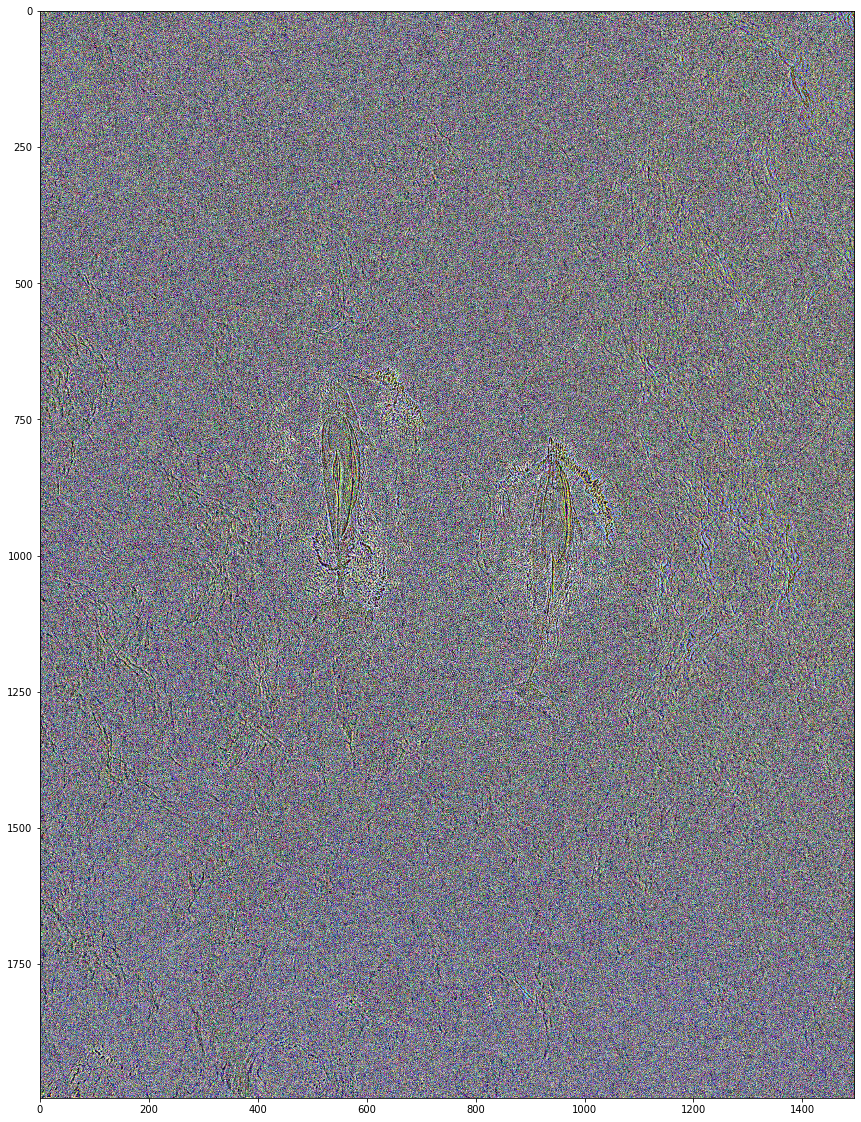

In [527]:
fig = plt.figure(figsize=(15, 20))
plt.imshow(Laplacian)

Here we extract the indexes of pixels within the mask.

In [528]:
mask_indices = np.where(mask > 0)
mask_indices = list(zip(*mask_indices))

This is how many pixels we have to fill.

In [529]:
np.count_nonzero(mask)

140470


Forming a matrix with this size is almost impossibale and even if it's not, it's surely not optimized and can cause major issues. This matrix has a special proparty which is most of it's elements are zero. These types of matrices are called Sparse matrices. We use SciPy.Sparse in almost every step of our calcu(lation to make our algorithm as efficient and fast as possible.
If we assueme $Ax=b$, A is a matrix with shape $N \times N$, where $N$ is the number of pixels in the specified region. Each row of this matrix has an element $4$ and at most four more $-1$s and the rest of the row is zero. The $b$ side on the other hand is the laplacian value of correspong pixel(row). Filling the $A$ in the most naive way is probably not a good idea becuase we have to perform so many iterations. Therefore we use rectangle around the mask to have structured shape. Now we can index the (row, col) pairs that have to be -1 in much easier way. They all almost place diagnally with or without offset.

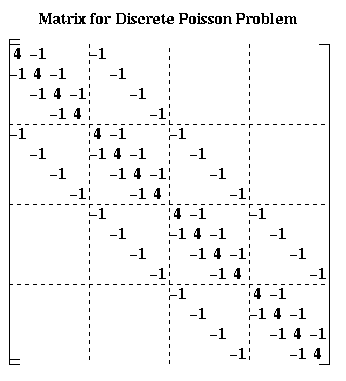

Most of the times we ignore the Laplacian of target image but in order to acheive a smoother texture on the water I dedicated a $0.25$ coefficient to target image laplacian and $0.75$ to source image laplacian.

After forming the matrices, we simply solve:

$$Ax=b$$

using scipy spsolve and then we just put back together the pixels to where they belong to. 

We apply a same procedure for each channel of the image and we finally merge them.

In [530]:
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix
from scipy.sparse import diags
from scipy.sparse import csr_matrix
import scipy
import scipy.sparse
from scipy.sparse.linalg import spsolve

moves = [(1, 0), (0, 1), (-1, 0), (0, -1)]

def apply_on_channel(source_channel, target_channel, L, mask_v, A, height, width):
    source_channel_vector = source_channel.flatten()
    target_channel_vector = target_channel.flatten()
    ratio = 0.75
    b = L @ (ratio * source_channel_vector + (1-ratio) * target_channel_vector)
    b[mask_v==0] = target_channel_vector[mask_v==0]
    x = spsolve(A, b)
    x = x.reshape((height, width))
    return clip(x)

def generate_mask(A, y_max, x_max):
    for y in range(1, y_max - 1):
        for x in range(1, x_max - 1):
            if mask[y, x] == 0:
                k = x + y * x_max
                A[k, k], A[k, k + 1], A[k, k - 1], A[k, k + x_max], A[k, k - x_max]  = 1, 0, 0, 0, 0

def get_laplacian(n, m):

    Diag = scipy.sparse.lil_matrix((m, m))
    Diag.setdiag(-1, -1)
    Diag.setdiag(4)
    Diag.setdiag(-1, 1)
        
    A = scipy.sparse.block_diag([Diag] * n).tolil()
    A.setdiag(-1, 1*m)
    A.setdiag(-1, -1*m)
    
    return A

def blend_poisson(source, target, mask):

    y_max, x_max = target.shape[:-1]

    mask = mask[:y_max, :x_max]    
    mask[mask != 0] = 1
    
    A = get_laplacian(y_max, x_max)

    L = A.tocsc()
    generate_mask(A, y_max, x_max)
    A = A.tocsc()

    mask_vector = mask.flatten()   

    for channel in range(3):
        target[:y_max, :x_max, channel] = \
        apply_on_channel(source[:y_max, :x_max, channel], target[:y_max, :x_max, channel], L, mask_vector, A, y_max, x_max)
        
    return target

def clip(v):
    new_v = np.copy(v)
    new_v[new_v > 255] = 255
    new_v[new_v < 0] = 0
    return new_v.astype(np.uint8)

Now we call the blend_poission function with given inputs, to get the result of blending of these 2 images.

In [531]:
result = blend_poisson(source, target, mask)

In [532]:
cv2.imwrite("res07.jpg", result)

True